In [5]:
## April 10 2017
## Judy Fan (jefan@)

#### This notebook provides a streamlined summary of analyses conducted in prepostRSA.ipynb:

## DESIGN ## ## ## ## 
## There are four objects (bed, bench, chair, table). Participants viewed each object 20 times per run.
## Runs 1 & 2 -- reserved to conduct searchlight
## Runs 3 & 4 -- pretest phase 
## Four training runs involving practice drawing two of the trained objects. 
## Runs 5 & 6 -- posttest phase

## GOAL ## ## ## ## 
## Compare similarity between Trained object representations before and after training (vs. Control) in several
## anatomically-defined ROIs. To do this, define `representation' as cope maps generated 
## upon fitting GLM to each object for each run. Build object x voxel matrix (4xK) for each run, vertically concatenate
## the two runs in each phase, and compute correlation matrix. Consider M = off-diagonal 4x4 block [:4,4:8].
## Make sure the rows are sorted such that the first two are the Trained, and the last two are the Control objects.
## Now take the the top-left 2x2 matrix within M and let's call it M-trained. The bottom-right 2x2 = M-control.
## The diagonal elements of M-trained (A,D depicted below) reflect the representational similarity for the *same* object between runs.
## The off diagonal elements of M-trained (B,C) reflect the similarity between different objects across runs. 
## [_A_|_B_]
## [_C_|_D_]
## Mean of (B,C) - Mean(A,D) = Representational distance between objects in this phase. 
## Do the above for the pretest, then for the posttest, and compare.

## ROIs = ['V1','fusiform','IT','LOC','occitemp']

## NOTE: On the 'sketchloop' machine, data are found in sketchloop02 directory at the same level as this 'neurosketch' 
## analysis directory, and are organized by subject.

import warnings
warnings.filterwarnings('ignore')

In [6]:
import numpy as np
import glob
import os
import scipy.stats as stats
from sklearn import metrics
import matplotlib
matplotlib.use("Pdf")
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
import seaborn as sns

import brainiak
import nilearn
import nibabel

from sklearn.metrics.pairwise import pairwise_distances as pd
from sklearn import svm
import sklearn
import analysis_helpers as helpers
import _pickle as cPickle

In [10]:
## Load in saved pkl
## columns are: Tradiffpost,Tradiffpre,Condiffpost,Condiffpre
## where: Tradiffpost = trabtw_mean_post - trawit_mean_post 
## generated by compare_btw_wit_cond_similarity_across_runs in prepostRSA.ipynb
with open('prepost_differentiation_by_condition.pkl', 'rb') as f:
    prepost_diff = cPickle.load(f, encoding='latin1') 
    
Tradiffpost = prepost_diff[0]    
Tradiffpre = prepost_diff[1]
Condiffpost = prepost_diff[2]
Condiffpre = prepost_diff[3]

In [11]:
## calculate post-pre change 
Tradifflearn = Tradiffpost-Tradiffpre
Condifflearn = Condiffpost-Condiffpre

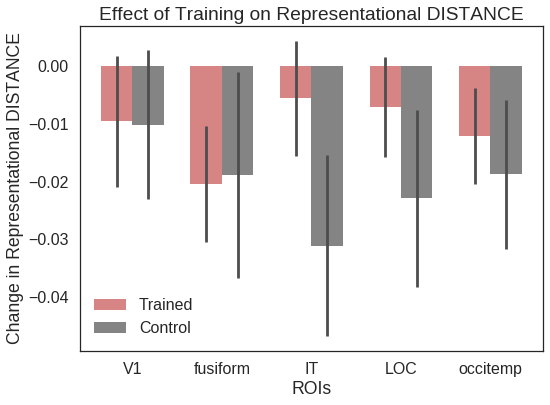

In [12]:
## Generate summary plot (main analysis)

plot_indiv_subs = 0

sns.set_style('white')
sns.set_context('poster')
means_trained = Tradifflearn.mean(1)
std_trained = Tradifflearn.std(1)/np.sqrt(shape(Tradifflearn)[1])

means_control = Condifflearn.mean(1)
std_control = Condifflearn.std(1)/np.sqrt(shape(Condifflearn)[1])


fig, ax = plt.subplots(figsize=(8,6))

n_groups = 5 # num ROIs
index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.8
error_config = {'ecolor': '0.3'}

## plot means as bars
tcolor = (0.8,0.4,0.4)
rects1 = plt.bar(index, means_trained, bar_width,
                 alpha=opacity,
                 color=(0.8,0.4,0.4),
                 yerr=std_trained,
                 error_kw=error_config,
                 label='Trained')

ccolor = (0.4,0.4,0.4)
rects2 = plt.bar(index + bar_width, means_control, bar_width,
                 alpha=opacity,
                 color=(0.4,0.4,0.4),
                 yerr=std_control,
                 error_kw=error_config,
                 label='Control')

if plot_indiv_subs:
    ## now plot individual subjects as dots
    def generate_concat_tiled(array,reps):        
        inds = []
        for i in index:
            inds.append(np.tile(i,reps))
        return np.reshape(np.array(inds),(1,reps*len(array)))

    tindex = generate_concat_tiled(index,len(Tradifflearn[0]))
    tsubdists = np.reshape(Tradifflearn,(1,shape(Tradifflearn)[0]*shape(Tradifflearn)[1]))
    plt.scatter(tindex,tsubdists,s=25,alpha=0.2,color=tcolor)

    cindex = generate_concat_tiled(index,len(Condifflearn[0]))+bar_width
    csubdists = np.reshape(Condifflearn,(1,shape(Condifflearn)[0]*shape(Condifflearn)[1]))
    plt.scatter(cindex,csubdists,s=25,alpha=0.2,color=ccolor)

plt.xlabel('ROIs')
plt.ylabel('Change in Representational DISTANCE')
plt.title('Effect of Training on Representational DISTANCE')
plt.xticks(index + bar_width / 2, ('V1','fusiform','IT','LOC','occitemp'))
plt.legend()

save_out = 0
if save_out:
    if plot_indiv_subs:
        helpers.save('plots/differentiation_by_roi_indiv_sub', ext='pdf', close=False, verbose=True)
    else:
        helpers.save('plots/differentiation_by_roi_group_mean', ext='pdf', close=False, verbose=True)

plt.tight_layout()
plt.show()